In [66]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool

In [67]:
df1=pd.read_csv("Train_UWu5bXk (1).csv")

In [68]:
#df2=pd.read_csv("Test_u94Q5KV (1).csv")

In [69]:
#data=pd.concat([df1,df2], ignore_index=True)

In [70]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [71]:
def alphabet(n):
    alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
    str=''
    r=len(alpha)-1   
    while len(str)<n:
        i=random.randint(0,r)
        str+=alpha[i]   
    return str

def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
    m_data={}
    m_data['run_id'] =run_id
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['scale']=scale
    m_data['classification']=classification
    m_data['scale']=False
    m_data['balance']=balance
    m_data['balance_threshold']=balance_threshold
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    m_data['analysis'] = analysis
    return m_data

def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()
    
def stackedensemble(mod):
    coef_norm=None
    try:
        metalearner = h2o.get_model(mod.metalearner()['name'])
        coef_norm=metalearner.coef_norm()
    except:
        pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
        if len(row['model_id'])>3:
            key=row['model_id'][0:3]
            if key in bm_algo:
                if bm_algo[key] is None:
                    bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id

def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d

def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

def model_performance_stats(perf):
    d={}
    try:    
        d['mse']=perf.mse()
    except:
        pass      
    try:    
        d['rmse']=perf.rmse() 
    except:
        pass      
    try:    
        d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_deviance']=perf.residual_deviance() 
    except:
        pass      
    try:    
        d['null_deviance']=perf.null_deviance() 
    except:
        pass      
    try:    
        d['aic']=perf.aic() 
    except:
        pass      
    try:
        d['logloss']=perf.logloss() 
    except:
        pass    
    try:
        d['auc']=perf.auc()
    except:
        pass  
    try:
        d['gini']=perf.gini()
    except:
        pass    
    return d

def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
        iv = pd.read_csv(i,header=None)
    except:
        sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
        ivd[c.strip()]=dt[i].strip()
        i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
            if dct[key] not in ['real','int','enum']:                      
                targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
            if dct[key] != val:
                print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                    df[key] = df[key].asfactor() 
                except:
                    targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                    df[key] = df[key].asnumeric() 
                except:
                    targ.remove(key)                  
            if dct[key]=='real':
                try:                
                    df[key] = df[key].asnumeric()  
                except:
                    targ.remove(key)                  
    if y is None:
        y=df.columns[-1] 
    if y in targ:
        targ.remove(y)
    else:
        y=targ.pop()            
    return targ

def check_X(x,df):
    for name in x:
        if name not in df.columns:
            x.remove(name)  
    return x 

def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
        if 'BestOfFamily' in model:
            se=model
        if se is None:     
            for model in model_set:
                if 'AllModels'in model:
                    se=model           
    return se 

def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d 

In [72]:
data_path= 'Train_UWu5bXk (1).csv'

In [73]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [74]:
run_id=alphabet(9)
# run_id to std out
print (run_id)

r9ze6Hr2T


In [75]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)

In [76]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=6,port=port_no)

Checking whether there is an H2O instance running at http://localhost:37220..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.141-b15, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\raksh\AppData\Local\Temp\tmpa0ogks8l
  JVM stdout: C:\Users\raksh\AppData\Local\Temp\tmpa0ogks8l\h2o_raksha_started_from_python.out
  JVM stderr: C:\Users\raksh\AppData\Local\Temp\tmpa0ogks8l\h2o_raksha_started_from_python.err
  Server is running at http://127.0.0.1:37220
Connecting to H2O server at http://127.0.0.1:37220... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,23 days
H2O cluster name:,H2O_from_python_raksha_t2m2xt
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [77]:
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': 'r9ze6Hr2T', 'start_time': 1539635043.150871, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1539635043.150871, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [78]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [79]:
df.describe()

Rows:8523
Cols:12




,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
type,enum,real,enum,real,enum,real,enum,int,enum,enum,enum,real
mins,,4.555,,0.0,,31.29,,1985.0,,,,33.29
mean,,12.857645184135976,,0.06613202877895108,,140.9927819781767,,1997.8318667135984,,,,2181.2889135750324
maxs,,21.35,,0.328390948,,266.8884,,2009.0,,,,13086.9648
sigma,,4.6434564991864145,,0.05159782232113511,,62.27506651219047,,8.371760408092635,,,,1706.4996157338326
zeros,,0,,526,,0,,0,,,,0
missing,0,1463,0,0,0,0,0,0,2410,0,0,0
0,FDA15,9.3,Low Fat,0.016047301,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.138
1,DRC01,5.92,Regular,0.019278216,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5,Low Fat,0.016760075,Meat,141.618,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.27


In [80]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
    target=df.columns[-1]   
y = target

In [81]:
if all_variables is not None:
    ivd=get_all_variables_csv(all_variables)
    print(ivd)    
    X=check_all_variables(df,ivd,y)
    print(X)

In [82]:
#df.describe()

In [83]:
# independent variables

X = []  
if all_variables is None:
    X=get_independent_variables(df, target)  
else: 
    ivd=get_all_variables_csv(all_variables)    
    X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [84]:
if analysis == 3:
    classification=False
elif analysis == 2:
    classification=True
elif analysis == 1:
    classification=True

In [85]:
print(classification)

False


In [86]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [87]:
def check_y(y,df):
    ok=False
    C = [name for name in df.columns if name == y]
    for key, val in df.types.items():
        if key in C:
            if val in ['real','int','enum']:        
                ok=True         
    return ok, val

In [88]:
ok,val=check_y(y,df)

In [89]:
print(val)

real


In [90]:
print(ok)

True


In [91]:
allV=get_variables_types(df)
allV

{'Item_Identifier': 'enum',
 'Item_Weight': 'real',
 'Item_Fat_Content': 'enum',
 'Item_Visibility': 'real',
 'Item_Type': 'enum',
 'Item_MRP': 'real',
 'Outlet_Identifier': 'enum',
 'Outlet_Establishment_Year': 'int',
 'Outlet_Size': 'enum',
 'Outlet_Location_Type': 'enum',
 'Outlet_Type': 'enum',
 'Item_Outlet_Sales': 'real'}

In [92]:
meta_data['variables']=allV

In [93]:
train, test = df.split_frame([0.9])

In [94]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [95]:
model_start_time = time.time()

In [96]:
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |█████████████████████████████████████████████████████████| 100%


In [97]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [98]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [99]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_AllModels_0_AutoML_20181015_162406,1.178391e+06,1085.536983,1.178391e+06,761.822857,NaN
1,GBM_grid_0_AutoML_20181015_162406_model_12,1.179802e+06,1086.186875,1.179802e+06,762.475335,0.550321
2,StackedEnsemble_BestOfFamily_0_AutoML_20181015_162406,1.191154e+06,1091.400039,1.191154e+06,770.103809,0.563734
3,GBM_grid_0_AutoML_20181015_162406_model_18,1.195747e+06,1093.502036,1.195747e+06,767.749246,0.550708
4,GBM_grid_0_AutoML_20181015_162406_model_20,1.196466e+06,1093.830770,1.196466e+06,779.562432,NaN
5,GBM_grid_0_AutoML_20181015_162406_model_5,1.206328e+06,1098.329700,1.206328e+06,772.373125,NaN
6,GBM_grid_0_AutoML_20181015_162406_model_25,1.207175e+06,1098.715147,1.207175e+06,788.856399,0.633765
7,GBM_grid_0_AutoML_20181015_162406_model_9,1.225325e+06,1106.943806,1.225325e+06,792.581845,0.636935
8,GBM_grid_0_AutoML_20181015_162406_model_19,1.228448e+06,1108.353558,1.228448e+06,775.803732,0.564939
9,GBM_grid_0_AutoML_20181015_162406_model_29,1.232078e+06,1109.989931,1.232078e+06,793.850340,0.634078


In [100]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [101]:
mod_best._id

'StackedEnsemble_AllModels_0_AutoML_20181015_162406'

In [102]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [103]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181015_162406


In [104]:
if se is not None:
    mod_best=h2o.get_model(se)

In [105]:
dir(mod_best)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_targets',
 '_compute_algo',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_make_model',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_verify_training_frame_params',
 '_xval_keys',
 'actual_params',
 'aic',
 'algo',
 'auc',
 'base_models',
 'biases',
 'catoffsets',
 'coef',
 'coef_norm',
 'cross_validation_fold_assignment',
 'cross_validation_holdout_predictions',
 'cross_validation_metrics_summary',
 'cross_validation_models',


In [106]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [107]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [108]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181015_162406
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 692156.9186344813
RMSE: 831.9596857026675
MAE: 583.1086674466
RMSLE: 0.4540617118524371
R^2: 0.764145473242541
Mean Residual Deviance: 692156.9186344813
Null degrees of freedom: 6140
Residual degrees of freedom: 6136
Null deviance: 18021853113.319267
Residual deviance: 4250535637.334349
AIC: 100020.9179681347

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 1176886.8848599254
RMSE: 1084.8441753818497
MAE: 760.9275304264653
RMSLE: 0.5598178485269191
R^2: 0.5838062547591437
Mean Residual Deviance: 1176886.8848599254
Null degrees of freedom: 1478
Residual degrees of freedom: 1474
Null deviance: 4182830333.0688252
Residual deviance: 1740615702.7078295
AIC: 24883.249047905505

ModelMetricsRegressionGLM: stackedensemble

In [109]:
bm=stackedensemble_df(aml_leaderboard_df)

In [110]:
bm

['GBM_grid_0_AutoML_20181015_162406_model_12',
 'GLM_grid_0_AutoML_20181015_162406_model_0',
 'DRF_0_AutoML_20181015_162406',
 'XRT_0_AutoML_20181015_162406',
 'DeepLearning_0_AutoML_20181015_162406']

In [111]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_AllModels_0_AutoML_20181015_162406,1.178391e+06,1085.536983,1.178391e+06,761.822857,NaN
1,GBM_grid_0_AutoML_20181015_162406_model_12,1.179802e+06,1086.186875,1.179802e+06,762.475335,0.550321
2,StackedEnsemble_BestOfFamily_0_AutoML_20181015_162406,1.191154e+06,1091.400039,1.191154e+06,770.103809,0.563734
3,GBM_grid_0_AutoML_20181015_162406_model_18,1.195747e+06,1093.502036,1.195747e+06,767.749246,0.550708
4,GBM_grid_0_AutoML_20181015_162406_model_20,1.196466e+06,1093.830770,1.196466e+06,779.562432,NaN
5,GBM_grid_0_AutoML_20181015_162406_model_5,1.206328e+06,1098.329700,1.206328e+06,772.373125,NaN
6,GBM_grid_0_AutoML_20181015_162406_model_25,1.207175e+06,1098.715147,1.207175e+06,788.856399,0.633765
7,GBM_grid_0_AutoML_20181015_162406_model_9,1.225325e+06,1106.943806,1.225325e+06,792.581845,0.636935
8,GBM_grid_0_AutoML_20181015_162406_model_19,1.228448e+06,1108.353558,1.228448e+06,775.803732,0.564939
9,GBM_grid_0_AutoML_20181015_162406_model_29,1.232078e+06,1109.989931,1.232078e+06,793.850340,0.634078


In [112]:
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
    if 'Intercept' in best_models.keys():
        del best_models['Intercept']
    bm=list(best_models.keys())
else:
    best_models={}
    bm=stackedensemble_df(aml_leaderboard_df)   
    for b in bm:   
        best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [113]:
bm

['GBM_grid_0_AutoML_20181015_162406_model_12',
 'DeepLearning_0_AutoML_20181015_162406',
 'XRT_0_AutoML_20181015_162406',
 'DRF_0_AutoML_20181015_162406',
 'GLM_grid_0_AutoML_20181015_162406_model_0',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181015_162406']

In [114]:
aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [115]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
1,GBM_grid_0_AutoML_20181015_162406_model_12,1.179802e+06,1086.186875,1.179802e+06,762.475335,0.550321
2,StackedEnsemble_BestOfFamily_0_AutoML_20181015_162406,1.191154e+06,1091.400039,1.191154e+06,770.103809,0.563734
12,DeepLearning_0_AutoML_20181015_162406,1.248707e+06,1117.455471,1.248707e+06,800.763998,0.585140
14,XRT_0_AutoML_20181015_162406,1.268780e+06,1126.401523,1.268780e+06,789.892532,0.557015
18,DRF_0_AutoML_20181015_162406,1.309373e+06,1144.278202,1.309373e+06,797.421259,0.556250
36,GLM_grid_0_AutoML_20181015_162406_model_0,2.935313e+06,1713.275608,2.935313e+06,1349.879604,1.087611


In [116]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [117]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GBM_grid_0_AutoML_20181015_162406_model_12


In [118]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

GBM_grid_0_AutoML_20181015_162406_model_12
gbm


In [119]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [120]:
meta_data['models']=bm

In [121]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
    try:   
        m=h2o.get_model(mod) 
        h2o.save_model(m, path = models_path)
    except:    
        pass

In [122]:
print(models_path)

C:\Users\raksh\Desktop\Fall 2018\Big Data-Nick brown\Big-Data-Intelligence-and-Analytics-\Assignment 2\Regression\r9ze6Hr2T\models


In [123]:
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass

{'algo': 'gbm', 'model_id': 'GBM_grid_0_AutoML_20181015_162406_model_12', 'varimp': [('Item_MRP', 28889847808.0, 1.0, 0.6490358396413476), ('Outlet_Identifier', 9087870976.0, 0.3145697075456189, 0.20416701426260392), ('Outlet_Type', 4698137088.0, 0.1626224242932502, 0.10554778169568112), ('Item_Identifier', 926742976.0, 0.03207849976085274, 0.020820096026719824), ('Item_Type', 697684544.0, 0.024149817217341017, 0.015674096894841998), ('Item_Weight', 115296600.0, 0.003990903682368059, 0.002590239522413499), ('Item_Visibility', 93293544.0, 0.0032292847169020297, 0.00209592151767548), ('Outlet_Size', 2523587.0, 8.735203510837408e-05, 5.669460145094404e-05), ('Outlet_Establishment_Year', 548201.875, 1.897558888656365e-05, 1.231583726567986e-05), ('Item_Fat_Content', 0.0, 0.0, 0.0), ('Outlet_Location_Type', 0.0, 0.0, 0.0)]}


In [124]:
# XRT

mod,mod_id=get_model_by_algo("XRT",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
    except:
         pass     
    try:        
        stats_xrt={}
        stats_xrt=xrt_stats(mod)
        n=run_id+'_xrt_stats.json'
        dict_to_json(stats_xrt,n)
        print(stats_xrt)
    except:
         pass

In [125]:
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
        cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
        cf_df=cf[0].table.as_data_frame()
        cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
        pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
        cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
        cf_df=cf[0].table.as_data_frame()
        cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
        pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions


In [126]:
predictions = mod_best.predict(test)    
predictions_df=test.cbind(predictions).as_data_frame() 
predictions_df.to_csv(run_id+'_predictions.csv')

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [167]:
c=abs(predictions_df['Item_Outlet_Sales']-predictions_df['predict'])
c.mean()

763.6011906564054

In [127]:

# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [128]:
meta_data

{'run_id': 'r9ze6Hr2T',
 'start_time': 1539635043.150871,
 'target': None,
 'max_models': 9,
 'run_time': 333,
 'scale': False,
 'classification': False,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1539635396.5764532,
 'execution_time': 353.42558217048645,
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'X': ['Outlet_Establishment_Year',
  'Item_Identifier',
  'Item_Fat_Content',
  'Item_Type',
  'Outlet_Identifier',
  'Outlet_Size',
  'Outlet_Location_Type',
  'Outlet_Type',
  'Item_Weight',
  'Item_Visibility',
  'Item_MRP'],
 'variables': {'Item_Identifier': 'enum',
  'Item_Weight': 'real',
  'Item_Fat_Content': 'enum',
  'Item_Visibility': 'real',
  'Item_Type': 'enum',
  'Item_MRP': 'real',
  'Outlet_Identifier': 'enum',
  'Outlet_Establishment_Year': 'int',
  'Outlet_Size': 'enum',
  'Outlet_Location_Type': 'enum',
  'Outlet_Type': 'enum',
  'Item_Outlet_Sales': 'real'},
 'model_execution_time': 348.8290183544159,
 'mod_best': 'GBM_grid_0_Aut

In [131]:
plots=aml.leaderboard

In [133]:
varImp=h2o.get_model(plots[1,"model_id"])

In [135]:
varImp.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,Item_MRP,2.888985e+10,1.000000,0.649036
1,Outlet_Identifier,9.087871e+09,0.314570,0.204167
2,Outlet_Type,4.698137e+09,0.162622,0.105548
3,Item_Identifier,9.267430e+08,0.032078,0.020820
4,Item_Type,6.976845e+08,0.024150,0.015674
5,Item_Weight,1.152966e+08,0.003991,0.002590
6,Item_Visibility,9.329354e+07,0.003229,0.002096
7,Outlet_Size,2.523587e+06,0.000087,0.000057
8,Outlet_Establishment_Year,5.482019e+05,0.000019,0.000012
9,Item_Fat_Content,0.000000e+00,0.000000,0.000000


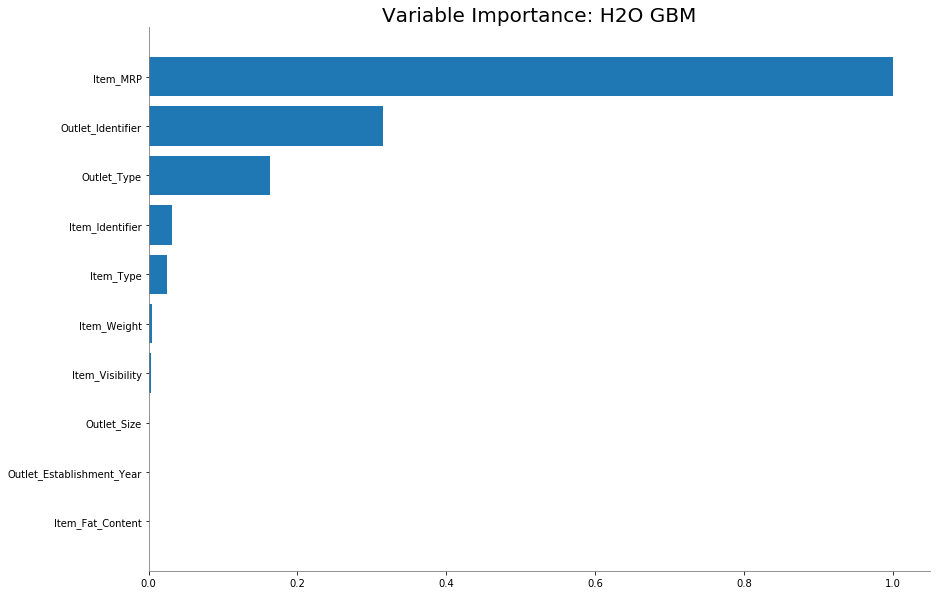

In [137]:
varImp.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_grid_0_AutoML_20181015_162406_model_12 on column 'Item_MRP'



item_mrp,mean_response,stddev_response,std_error_mean_response
31.29,665.5977559,274.6090343,2.9745315
43.6899158,665.5977559,274.6090343,2.9745315
56.0898316,882.3105592,349.5444873,3.7862232
68.4897474,1084.3467653,417.2620692,4.5197318
80.8896632,1257.4777218,453.4381912,4.9115871
93.2895789,1397.6870458,536.3205779,5.8093590
105.6894947,1558.4076537,574.3216421,6.2209819
118.0894105,1749.3140481,626.4033622,6.7851247
130.4893263,2058.9166344,739.1659839,8.0065557
142.8892421,2058.9166344,739.1659839,8.0065557


PartialDependence: Partial Dependence Plot of model GBM_grid_0_AutoML_20181015_162406_model_12 on column 'Outlet_Identifier'



outlet_identifier,mean_response,stddev_response,std_error_mean_response
OUT010,997.4339660,627.7542587,6.7997575
OUT013,2275.0382171,1057.5146996,11.4548701
OUT017,2295.3991342,1036.5622454,11.2279157
OUT018,1983.8359517,917.4951279,9.9381952
OUT019,997.4339660,627.7542587,6.7997575
OUT027,3031.2863301,1460.9927144,15.8252947
OUT035,2390.7820905,1091.5811084,11.8238733
OUT045,2184.8728392,1019.2224072,11.0400927
OUT046,2266.8966955,1013.9538404,10.9830242
OUT049,2346.1424850,1074.9991286,11.6442593


PartialDependence: Partial Dependence Plot of model GBM_grid_0_AutoML_20181015_162406_model_12 on column 'Outlet_Type'



outlet_type,mean_response,stddev_response,std_error_mean_response
Grocery Store,1618.7473228,854.5373404,9.2562441
Supermarket Type1,2193.9221001,1161.8295822,12.5847962
Supermarket Type2,2136.8144100,1128.9643041,12.2288035
Supermarket Type3,2768.0940752,1243.0557485,13.4646281


PartialDependence: Partial Dependence Plot of model GBM_grid_0_AutoML_20181015_162406_model_12 on column 'Item_Type'



item_type,mean_response,stddev_response,std_error_mean_response
Baking Goods,2218.5738510,1297.2424824,14.0515722
Breads,2206.4809382,1288.5025754,13.9569026
Breakfast,2220.4691622,1386.6634442,15.0201691
Canned,2189.9064017,1292.6565959,14.0018984
Dairy,2166.8585664,1348.6602759,14.6085234
Frozen Foods,2184.8801956,1338.2238368,14.4954772
Fruits and Vegetables,2164.8178009,1299.1278697,14.0719945
Hard Drinks,2172.2941559,1320.1796531,14.3000248
Health and Hygiene,2184.2697119,1301.2421335,14.0948959
Household,2172.2151770,1306.2499667,14.1491401


PartialDependence: Partial Dependence Plot of model GBM_grid_0_AutoML_20181015_162406_model_12 on column 'Item_Weight'



item_weight,mean_response,stddev_response,std_error_mean_response
4.555,2202.0872677,1300.0614902,14.0821073
5.4389474,2202.0872677,1300.0614902,14.0821073
6.3228947,2182.3565785,1315.2759659,14.2469087
7.2068421,2182.3565785,1315.2759659,14.2469087
8.0907895,2182.3565785,1315.2759659,14.2469087
8.9747368,2182.3565785,1315.2759659,14.2469087
9.8586842,2182.3565785,1315.2759659,14.2469087
10.7426316,2182.3565785,1315.2759659,14.2469087
11.6265789,2182.3565785,1315.2759659,14.2469087
12.5105263,2182.3565785,1315.2759659,14.2469087


[, , , , ]

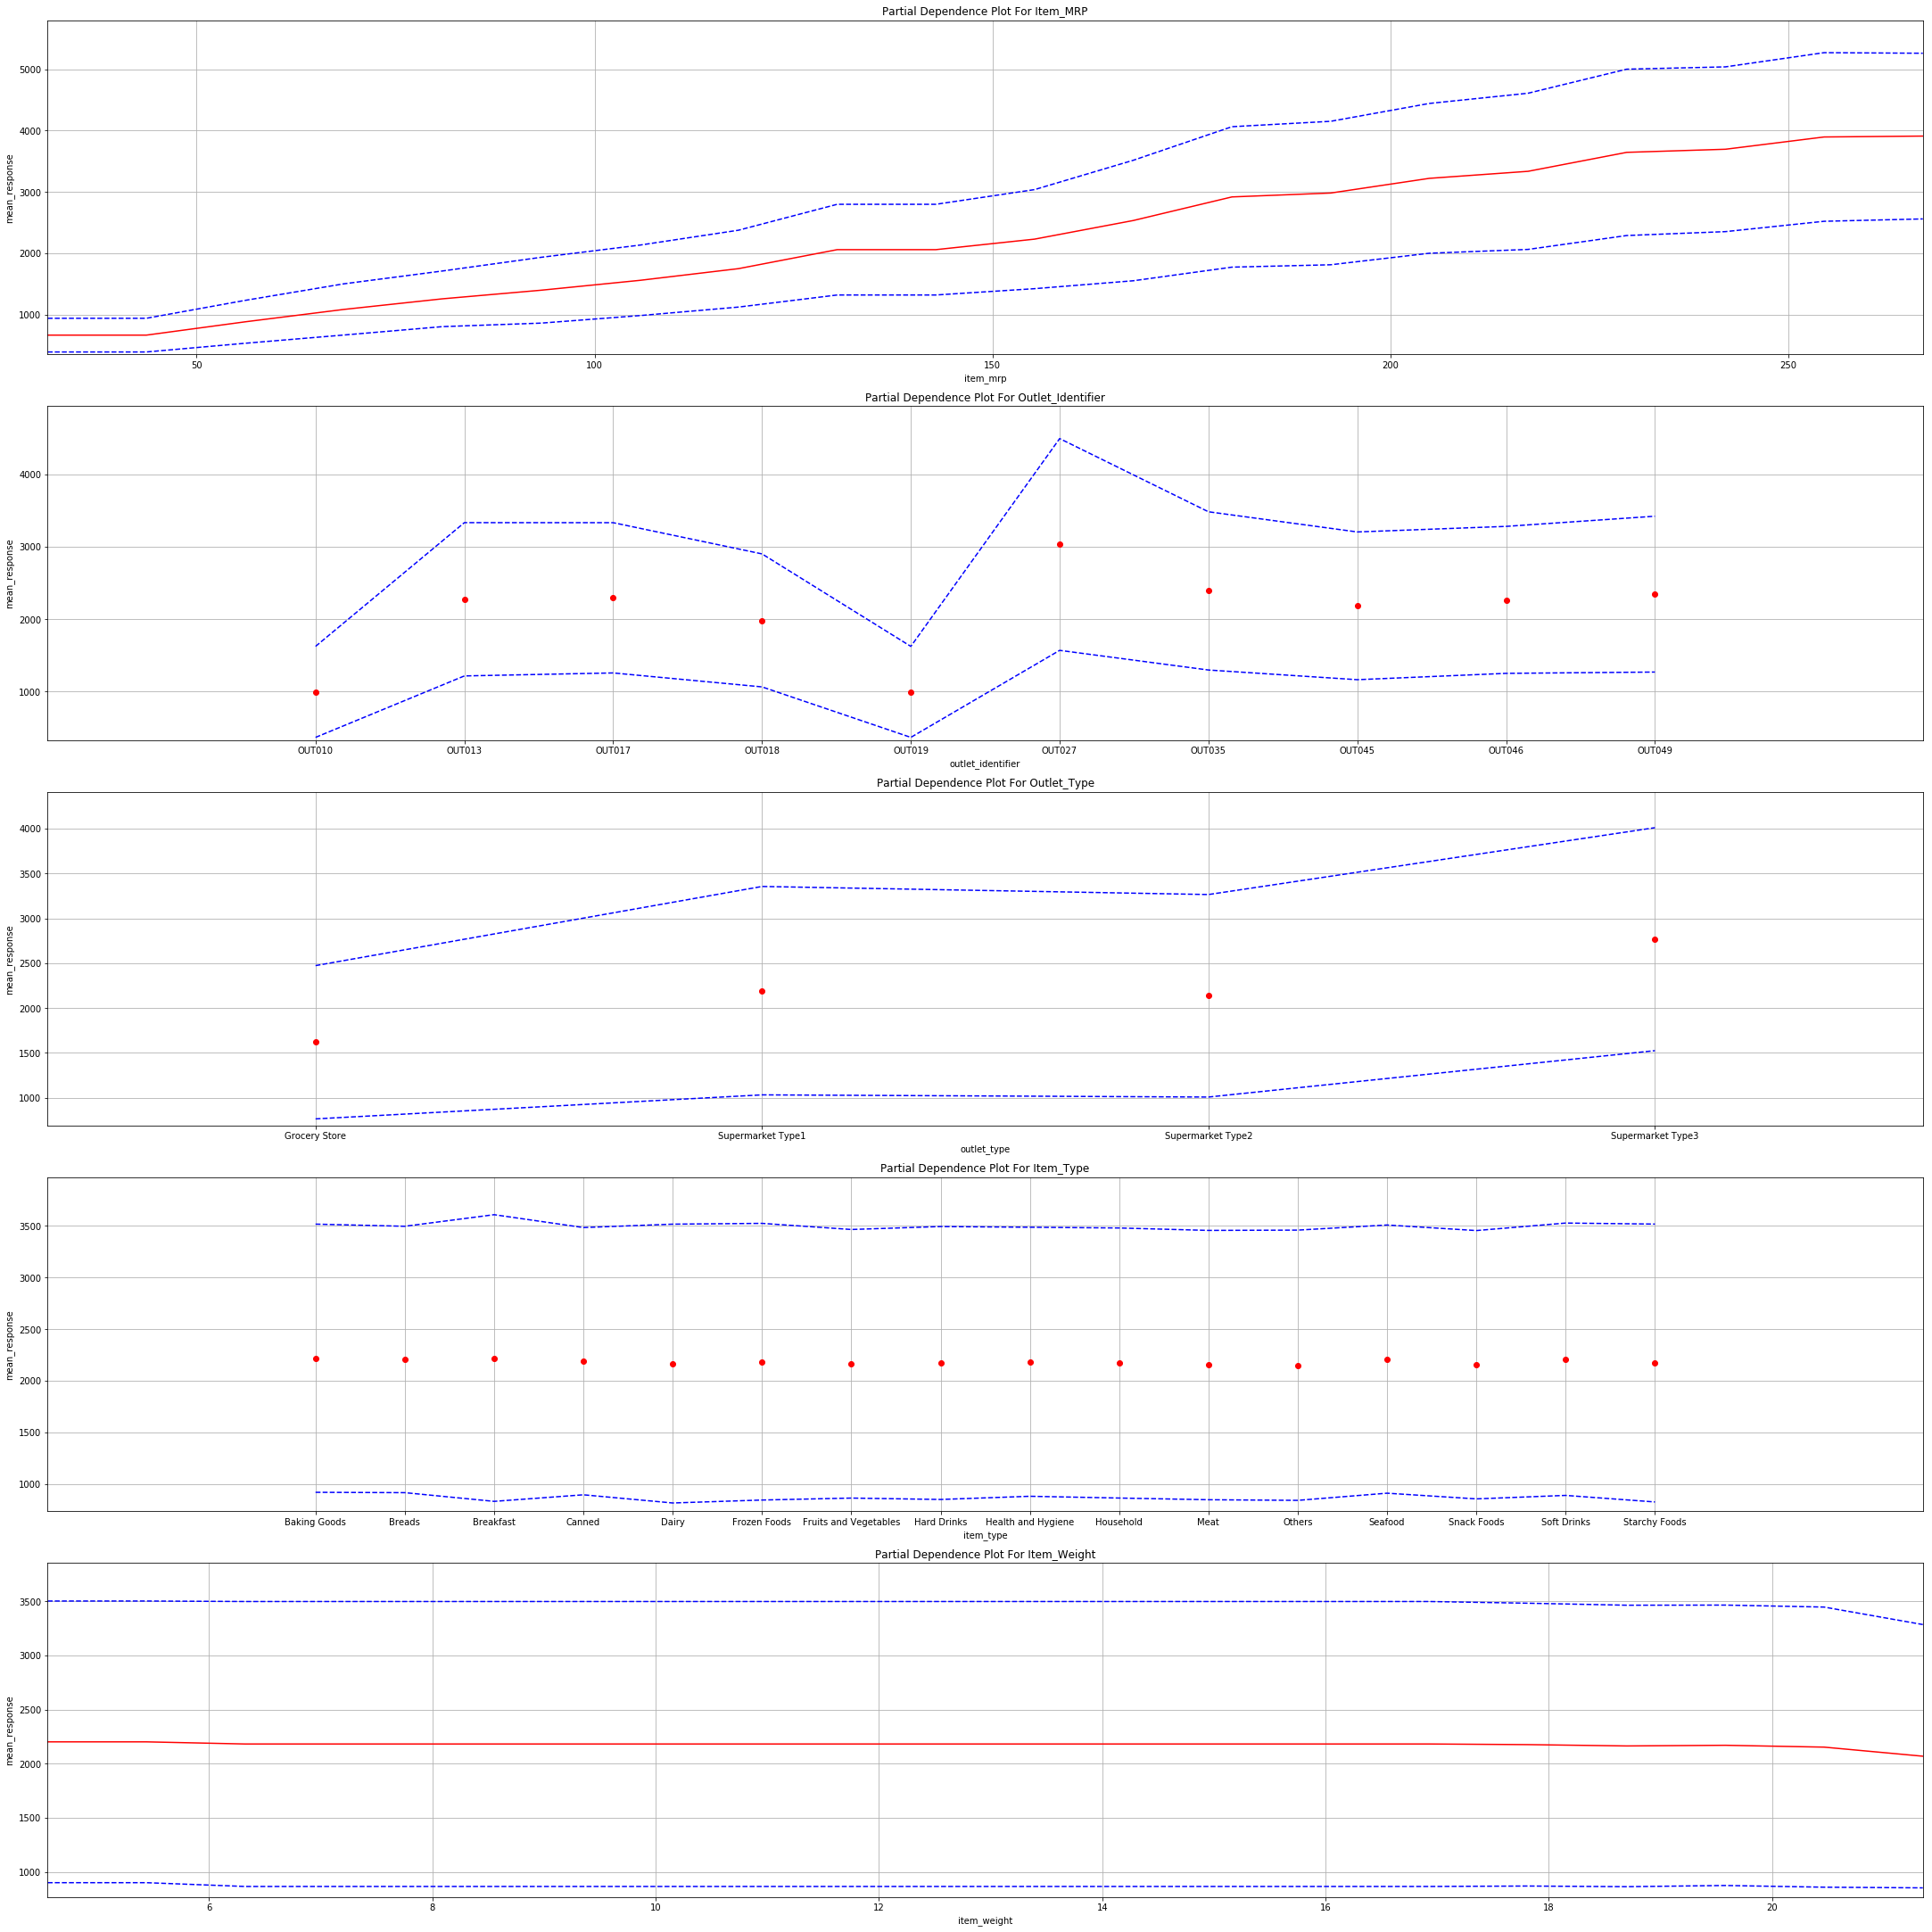

In [147]:
varImp.partial_plot(data=df, cols=['Item_MRP','Outlet_Identifier','Outlet_Type','Item_Type','Item_Weight'], figsize=(30,30))

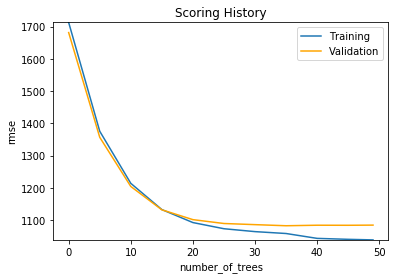

In [152]:
varImp.plot()

In [155]:
varImp.model_performance

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_0_AutoML_20181015_162406_model_12


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1078634.5389411903
RMSE: 1038.5733190012106
MAE: 729.5838233973843
RMSLE: NaN
Mean Residual Deviance: 1078634.5389411903

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 1175973.309804499
RMSE: 1084.4230308345996
MAE: 758.2964433108918
RMSLE: 0.5611744952343632
Mean Residual Deviance: 1175973.309804499

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1179801.9264264572
RMSE: 1086.1868745416036
MAE: 762.4753349408207
RMSLE: 0.5503213009510398
Mean Residual Deviance: 1179801.9264264572
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,762.4737,7.8026443,772.38135,769.54504,753.97217,744.96027,771.50977
mean_residual_deviance,1179795.0,29907.502,1222369.1,1194892.1,1104114.8,1166278.0,1211321.0
mse,1179795.0,29907.502,1222369.1,1194892.1,1104114.8,1166278.0,1211321.0
r2,0.5973346,0.0086156,0.6057899,0.6155896,0.5961638,0.5823236,0.5868063
residual_deviance,1179795.0,29907.502,1222369.1,1194892.1,1104114.8,1166278.0,1211321.0
rmse,1086.0063,13.878558,1105.608,1093.1112,1050.7687,1079.9435,1100.6003
rmsle,0.5501897,0.0085317,0.5459547,0.5501559,0.5446732,0.5373110,0.5728539


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-10-15 16:26:42,46.184 sec,0.0,1713.0899771,1349.6823046,2934677.2697149,1681.7097318,1325.1451345,2828147.6220885
,2018-10-15 16:26:42,46.201 sec,5.0,1375.6727975,1062.3588100,1892475.6458794,1356.9810411,1049.3250961,1841397.5460214
,2018-10-15 16:26:42,46.218 sec,10.0,1214.0466433,915.8495468,1473909.2520451,1204.3154475,906.6897025,1450375.6969871
,2018-10-15 16:26:42,46.237 sec,15.0,1132.6408410,835.3935188,1282875.2746271,1131.8862008,832.1036625,1281166.3716592
,2018-10-15 16:26:42,46.259 sec,20.0,1092.3253269,794.2181062,1193174.6198691,1101.4020849,797.0895306,1213086.5526687
,2018-10-15 16:26:42,46.280 sec,25.0,1073.1970665,770.4631360,1151751.9434510,1089.4182810,777.7607331,1186832.1909055
,2018-10-15 16:26:42,46.299 sec,30.0,1064.2250114,756.3419078,1132574.8749578,1085.8912875,766.6602965,1179159.8882518
,2018-10-15 16:26:42,46.319 sec,35.0,1058.3782692,749.2251268,1120164.5607337,1082.4612814,761.4115644,1171722.4257620
,2018-10-15 16:26:42,46.344 sec,40.0,1043.2777723,734.6800871,1088428.5101615,1084.0869150,760.9174013,1175244.4392678
,2018-10-15 16:26:42,46.367 sec,45.0,1040.3340813,732.4453094,1082295.0007157,1083.9037743,760.0508782,1174847.3918354


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Item_MRP,28889847808.0000000,1.0,0.6490358
Outlet_Identifier,9087870976.0000000,0.3145697,0.2041670
Outlet_Type,4698137088.0000000,0.1626224,0.1055478
Item_Identifier,926742976.0000000,0.0320785,0.0208201
Item_Type,697684544.0000000,0.0241498,0.0156741
Item_Weight,115296600.0000000,0.0039909,0.0025902
Item_Visibility,93293544.0000000,0.0032293,0.0020959
Outlet_Size,2523587.0,0.0000874,0.0000567
Outlet_Establishment_Year,548201.8750000,0.0000190,0.0000123
Item_Fat_Content,0.0,0.0,0.0


<bound method ModelBase.model_performance of >

In [157]:
varImp.mae()

729.5838233973843

In [159]:
varImp.rmse()

1038.5733190012106

In [160]:
varImp.r2()

0.6324520757112159

In [161]:
varImp.get_params

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_0_AutoML_20181015_162406_model_12


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1078634.5389411903
RMSE: 1038.5733190012106
MAE: 729.5838233973843
RMSLE: NaN
Mean Residual Deviance: 1078634.5389411903

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 1175973.309804499
RMSE: 1084.4230308345996
MAE: 758.2964433108918
RMSLE: 0.5611744952343632
Mean Residual Deviance: 1175973.309804499

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1179801.9264264572
RMSE: 1086.1868745416036
MAE: 762.4753349408207
RMSLE: 0.5503213009510398
Mean Residual Deviance: 1179801.9264264572
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,762.4737,7.8026443,772.38135,769.54504,753.97217,744.96027,771.50977
mean_residual_deviance,1179795.0,29907.502,1222369.1,1194892.1,1104114.8,1166278.0,1211321.0
mse,1179795.0,29907.502,1222369.1,1194892.1,1104114.8,1166278.0,1211321.0
r2,0.5973346,0.0086156,0.6057899,0.6155896,0.5961638,0.5823236,0.5868063
residual_deviance,1179795.0,29907.502,1222369.1,1194892.1,1104114.8,1166278.0,1211321.0
rmse,1086.0063,13.878558,1105.608,1093.1112,1050.7687,1079.9435,1100.6003
rmsle,0.5501897,0.0085317,0.5459547,0.5501559,0.5446732,0.5373110,0.5728539


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-10-15 16:26:42,46.184 sec,0.0,1713.0899771,1349.6823046,2934677.2697149,1681.7097318,1325.1451345,2828147.6220885
,2018-10-15 16:26:42,46.201 sec,5.0,1375.6727975,1062.3588100,1892475.6458794,1356.9810411,1049.3250961,1841397.5460214
,2018-10-15 16:26:42,46.218 sec,10.0,1214.0466433,915.8495468,1473909.2520451,1204.3154475,906.6897025,1450375.6969871
,2018-10-15 16:26:42,46.237 sec,15.0,1132.6408410,835.3935188,1282875.2746271,1131.8862008,832.1036625,1281166.3716592
,2018-10-15 16:26:42,46.259 sec,20.0,1092.3253269,794.2181062,1193174.6198691,1101.4020849,797.0895306,1213086.5526687
,2018-10-15 16:26:42,46.280 sec,25.0,1073.1970665,770.4631360,1151751.9434510,1089.4182810,777.7607331,1186832.1909055
,2018-10-15 16:26:42,46.299 sec,30.0,1064.2250114,756.3419078,1132574.8749578,1085.8912875,766.6602965,1179159.8882518
,2018-10-15 16:26:42,46.319 sec,35.0,1058.3782692,749.2251268,1120164.5607337,1082.4612814,761.4115644,1171722.4257620
,2018-10-15 16:26:42,46.344 sec,40.0,1043.2777723,734.6800871,1088428.5101615,1084.0869150,760.9174013,1175244.4392678
,2018-10-15 16:26:42,46.367 sec,45.0,1040.3340813,732.4453094,1082295.0007157,1083.9037743,760.0508782,1174847.3918354


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Item_MRP,28889847808.0000000,1.0,0.6490358
Outlet_Identifier,9087870976.0000000,0.3145697,0.2041670
Outlet_Type,4698137088.0000000,0.1626224,0.1055478
Item_Identifier,926742976.0000000,0.0320785,0.0208201
Item_Type,697684544.0000000,0.0241498,0.0156741
Item_Weight,115296600.0000000,0.0039909,0.0025902
Item_Visibility,93293544.0000000,0.0032293,0.0020959
Outlet_Size,2523587.0,0.0000874,0.0000567
Outlet_Establishment_Year,548201.8750000,0.0000190,0.0000123
Item_Fat_Content,0.0,0.0,0.0


<bound method H2OEstimator.get_params of >

In [129]:
#os.chdir(server_path)

In [130]:
#h2o.cluster().shutdown()